In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
# Transform: Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean & std
])

# Download datasets
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:18<00:00, 526kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 98.6kB/s]
100%|██████████| 1.65M/1.65M [00:29<00:00, 55.2kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.12MB/s]


加入残差块（参考https://stackoverflow.com/questions/60817390/implementing-a-simple-resnet-block-with-pytorch）

In [10]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = self.skip(x)
        out = self.block(x)
        out += identity
        out = F.relu(out)
        return out

In [11]:
class CNN_res(nn.Module):
    def __init__(self):
        super(CNN_res, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(32)
        #残差块1
        self.resblock1=ResBlock(32,32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)#28x28 → 14x14 

        #残差块2
        self.resblock2=ResBlock(32,64,stride=2)#14x14 → 7x7
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # MNIST is 28x28 → 7x7 after pooling twice
        self.fc2 = nn.Linear(128, 10)  # 10 classes (digits 0-9)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x=F.relu(self.bn1(x))          
        x = self.resblock1(x)      
        x = self.pool(x)          
        x = self.resblock2(x)      
        x = x.view(-1, 64 * 7 * 7) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

In [12]:
model = CNN_res().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    accuracy = 100 * correct / len(test_loader.dataset)
    
    print(
        f"Epoch {epoch+1}/{epochs}, "
        f"Train Loss: {epoch_loss:.4f}, "
        f"Test Loss: {test_loss:.4f}, "
        f"Accuracy: {accuracy:.2f}%"
    )

Epoch 1/10, Train Loss: 0.1609, Test Loss: 0.0380, Accuracy: 98.78%
Epoch 2/10, Train Loss: 0.0693, Test Loss: 0.0326, Accuracy: 99.02%
Epoch 3/10, Train Loss: 0.0524, Test Loss: 0.0258, Accuracy: 99.22%
Epoch 4/10, Train Loss: 0.0437, Test Loss: 0.0253, Accuracy: 99.24%
Epoch 5/10, Train Loss: 0.0347, Test Loss: 0.0250, Accuracy: 99.25%
Epoch 6/10, Train Loss: 0.0294, Test Loss: 0.0254, Accuracy: 99.25%
Epoch 7/10, Train Loss: 0.0262, Test Loss: 0.0286, Accuracy: 99.08%
Epoch 8/10, Train Loss: 0.0241, Test Loss: 0.0280, Accuracy: 99.20%
Epoch 9/10, Train Loss: 0.0208, Test Loss: 0.0273, Accuracy: 99.13%
Epoch 10/10, Train Loss: 0.0174, Test Loss: 0.0296, Accuracy: 99.23%


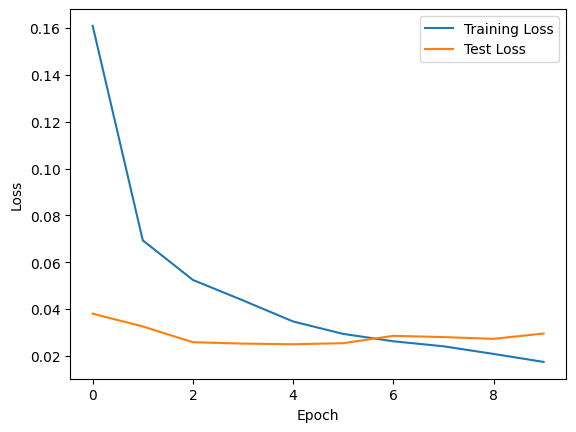

In [13]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()